# ELL881 : Assignment 3

In this assignment, you will be building a named entity recognition (NER) model using a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model. NER is a subtask of information extraction that involves identifying and classifying named entities in text into predefined categories such as person names, organization names, locations, and more.

Broadly the steps involved will be as follows:

1. **Data Preparation**: You will process the dataset given to you and tokenize it.
2. **Fine-Tuning BERT**: You will fine-tune a pre-trained BERT model for sequence classification using the training set. You will use the Hugging Face Transformers library to load the pre-trained BERT model and customize the final layers for NER. You will also define the loss function, optimizer, and learning rate scheduler.
3. **Model Evaluation**: You will evaluate the performance of the trained model using the test set on the accuracy metric. 

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from sklearn.model_selection import train_test_split
from transformers import AdamW
import torch.optim as optim
from transformers import DataCollatorForTokenClassification
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Preparation

### Dataset description
The labels in this dataset are as follows:
* `geo` for geographical entity
* `org` for organization entity
* `per` for person entity
* `gpe` for geopolitical entity
* `tim` for time indicator entity
* `art` for artifact entity
* `eve` for event entity
* `nat` for natural phenomenon entity
* `O` is assigned if a word doesn’t belong to any entity.

The labels have also been tagged using the BIO scheme.
You can use the following code for getting the list of labels.

In [2]:
df = pd.read_csv("/kaggle/input/dataset3/ner.csv")
# df = df.head(20)

# We split the data into train, validation and test sets (80-10-10 split)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

tag2id = {}

tags = ['O','geo','org','per','gpe','tim','art','eve','nat']

for t in tags:
    if(t!='O'):
        tag2id['B-'+t] = len(tag2id)
        tag2id['I-'+t] = len(tag2id)
    else:
        tag2id[t] = len(tag2id)

def preprocess(df):
    texts  = np.array(df['text'])
    labels = np.array(df['labels'])    
    updated_texts = []
    updated_labels = []

    for text,label in zip(texts,labels): 
        if(len(text.split())!=len(label.split())):
            continue;

        updated_texts.append(text.split())
        updated_labels.append(label.split())

    texts = updated_texts
    labels = updated_labels

    tokens = tokenizer(texts, truncation=True,padding=True, is_split_into_words=True)
    
    label_ids = []
    split_spans = []
    
    for i,label in enumerate(labels):
        span_ids = tokens.word_ids(batch_index=i)
        prev = None
        
        label_id = []
        
        for i,idx in enumerate(span_ids):
            if idx is None:
                label_id.append(-100)
                span_ids[i] = -1
            elif(idx!=prev):
                label_id.append(tag2id[label[idx]])
            else:
                if(label[idx]=="O"):
                    label_id.append(tag2id[label[idx]])
                else:     
                    newlab = 'I' + label[idx][1:]
                    label_id.append(tag2id[newlab])
                    
            prev = idx
        label_ids.append(label_id)
        split_spans.append(span_ids)
    tokens["labels"] = label_ids
#     print(len(tokens["input_ids"][0]))
    
    return tokens,texts,labels,torch.tensor(split_spans)

train_tokens,train_text,train_labels,train_spans = preprocess(df_train)
val_tokens,val_text,val_labels,val_spans = preprocess(df_val)
test_tokens,test_text,test_labels,test_spans = preprocess(df_test)

In [3]:
train_inputs = torch.tensor(train_tokens['input_ids'])
train_attention_masks = torch.tensor(train_tokens['attention_mask'])
train_labels = torch.tensor(train_tokens['labels'])

val_inputs = torch.tensor(val_tokens['input_ids'])
val_attention_masks = torch.tensor(val_tokens['attention_mask'])
val_labels = torch.tensor(val_tokens['labels'])

test_inputs = torch.tensor(test_tokens['input_ids'])
test_attention_masks = torch.tensor(test_tokens['attention_mask'])
test_labels = torch.tensor(test_tokens['labels'])

# Convert to TensorDataset
train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels,train_spans)
val_dataset  = TensorDataset(val_inputs, val_attention_masks, val_labels,val_spans)
test_dataset = TensorDataset(test_inputs, test_attention_masks, test_labels,test_spans)

# Define batch size
batch_size = 32

# Define data loaders for training, validation and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

unique_labels = tag2id

## Model Building

In this assignment, you will be using a pretrained BERT model from HuggingFace (supplied in the `transformers` library).
This is a classification task hence the model that you should make use of `BertForTokenClassification` model.

You can train the model using GPU. You should ideally get the script ready on your system by taking a small subset of data and then train it completely using an online service such as Google Colab or Kaggle.

Further, the model expects the inputs to supplied in a particular format which you should be able to read online in the documentations and other resources like medium articles (read up on using BERT for NLP tasks in Pytorch and you will find a lot of resources online). Additionally, for performing tokenization you should be using the tokenizer supplied in the transformers library. The imports for the same have been done in the code snippet below:

In [4]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# Note how we are using the cased version of tokenizer here since the labels leverage the case information


class BertModel(torch.nn.Module):

    def __init__(self):
        super(BertModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)
        return output


In [5]:
def evaluate(model,dataloader,lab):
    model.eval()
    test_loss = 0
    
    test_actual = []
    test_preds  = []
    
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            spans   = batch[3].to(device)

            outputs = model(input_ids,attention_mask,labels)
            _, logits = outputs[:2]
            loss = loss_fn(logits.view(-1, len(unique_labels)), labels.view(-1))
            test_loss += loss.item()

            probs = torch.nn.functional.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)
            
            for i,span in enumerate(spans):
                pre = None
                label = labels[i].cpu().numpy()
                pred  = preds[i].cpu().numpy()
                for j in range(len(span)):
                    if(span[j]==-1):
                        continue
                    else:
                        if(span[j]!=pre):
                            test_actual.append(label[j])
                            test_preds.append(pred[j])
                    pre = span[j]
    
    test_actual_wO = []
    test_preds_wO  = []
    
    for i in range(len(test_actual)):
        if(test_actual[i]!=0):
            test_actual_wO.append(test_actual[i])
            test_preds_wO.append(test_preds[i])
            
    test_f1 = f1_score(test_actual, test_preds, average='weighted')
    a = f1_score(test_actual, test_preds, average='micro')
    b = f1_score(test_actual, test_preds, average='macro')
    accuracy = accuracy_score(test_actual, test_preds)
    
    test_f1_wO = f1_score(test_actual_wO, test_preds_wO, average='weighted')
    a1 = f1_score(test_actual_wO, test_preds_wO, average='micro')
    b1 = f1_score(test_actual_wO, test_preds_wO, average='macro')
    accuracy_wO = accuracy_score(test_actual_wO, test_preds_wO)
    
    return test_f1,accuracy,test_f1_wO,accuracy_wO, (a+b)/2, (a1+b1)/2

## Model Training

In [6]:
def train(wd):
    # Initialize the model, optimizer, and learning rate scheduler
    model = BertModel()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=wd)
    epochs = 20
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset)*epochs)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()


    # Train the model
    model.to(device)
    model.train()

    for epoch in range(epochs):
        for step, batch in enumerate(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids,attention_mask,labels)
            _, logits = outputs[:2]
            loss = loss_fn(logits.view(-1, len(unique_labels)), labels.view(-1))

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            if step % 1 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Batch {step+1}/{len(train_dataloader)} - Loss: {loss.item()}",end="\r")
        print(f"Epoch {epoch+1}/{epochs} - Batch {len(train_dataloader)}/{len(train_dataloader)} - Loss: {loss.item()}")
        
    return model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epoch 1/5 - Batch 1199/1199 - Loss: 0.150756433606147776
Epoch 2/5 - Batch 1199/1199 - Loss: 0.156630948185920726
Epoch 3/5 - Batch 1199/1199 - Loss: 0.093555003404617314
Epoch 4/5 - Batch 1199/1199 - Loss: 0.042238339781761174
Epoch 5/5 - Batch 1199/1199 - Loss: 0.032024141401052475


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epoch 1/5 - Batch 1199/1199 - Loss: 0.109644822776317644
Epoch 2/5 - Batch 1199/1199 - Loss: 0.062488235533237464
Epoch 3/5 - Batch 1199/1199 - Loss: 0.063061624765396125
Epoch 4/5 - Batch 1199/1199 - Loss: 0.058987893164157875
Epoch 5/5 - Batch 1199/1199 - Loss: 0.024460982531309128


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epoch 1/5 - Batch 1199/1199 - Loss: 0.136154681444168136
Epoch 2/5 - Batch 1199/1199 - Loss: 0.182007372379302986
Epoch 3/5 - Batch 1199/1199 - Loss: 0.080407917499542244
Epoch 4/5 - Batch 1199/1199 - Loss: 0.061547424644231796
Epoch 5/5 - Batch 1199/1199 - Loss: 0.017750769853591927


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epoch 1/5 - Batch 1199/1199 - Loss: 0.159784689545631464
Epoch 2/5 - Batch 1199/1199 - Loss: 0.041637733578681946
Epoch 3/5 - Batch 1199/1199 - Loss: 0.086809948086738596
Epoch 4/5 - Batch 1199/1199 - Loss: 0.120832063257694242
Epoch 5/5 - Batch 1199/1199 - Loss: 0.028426183387637144


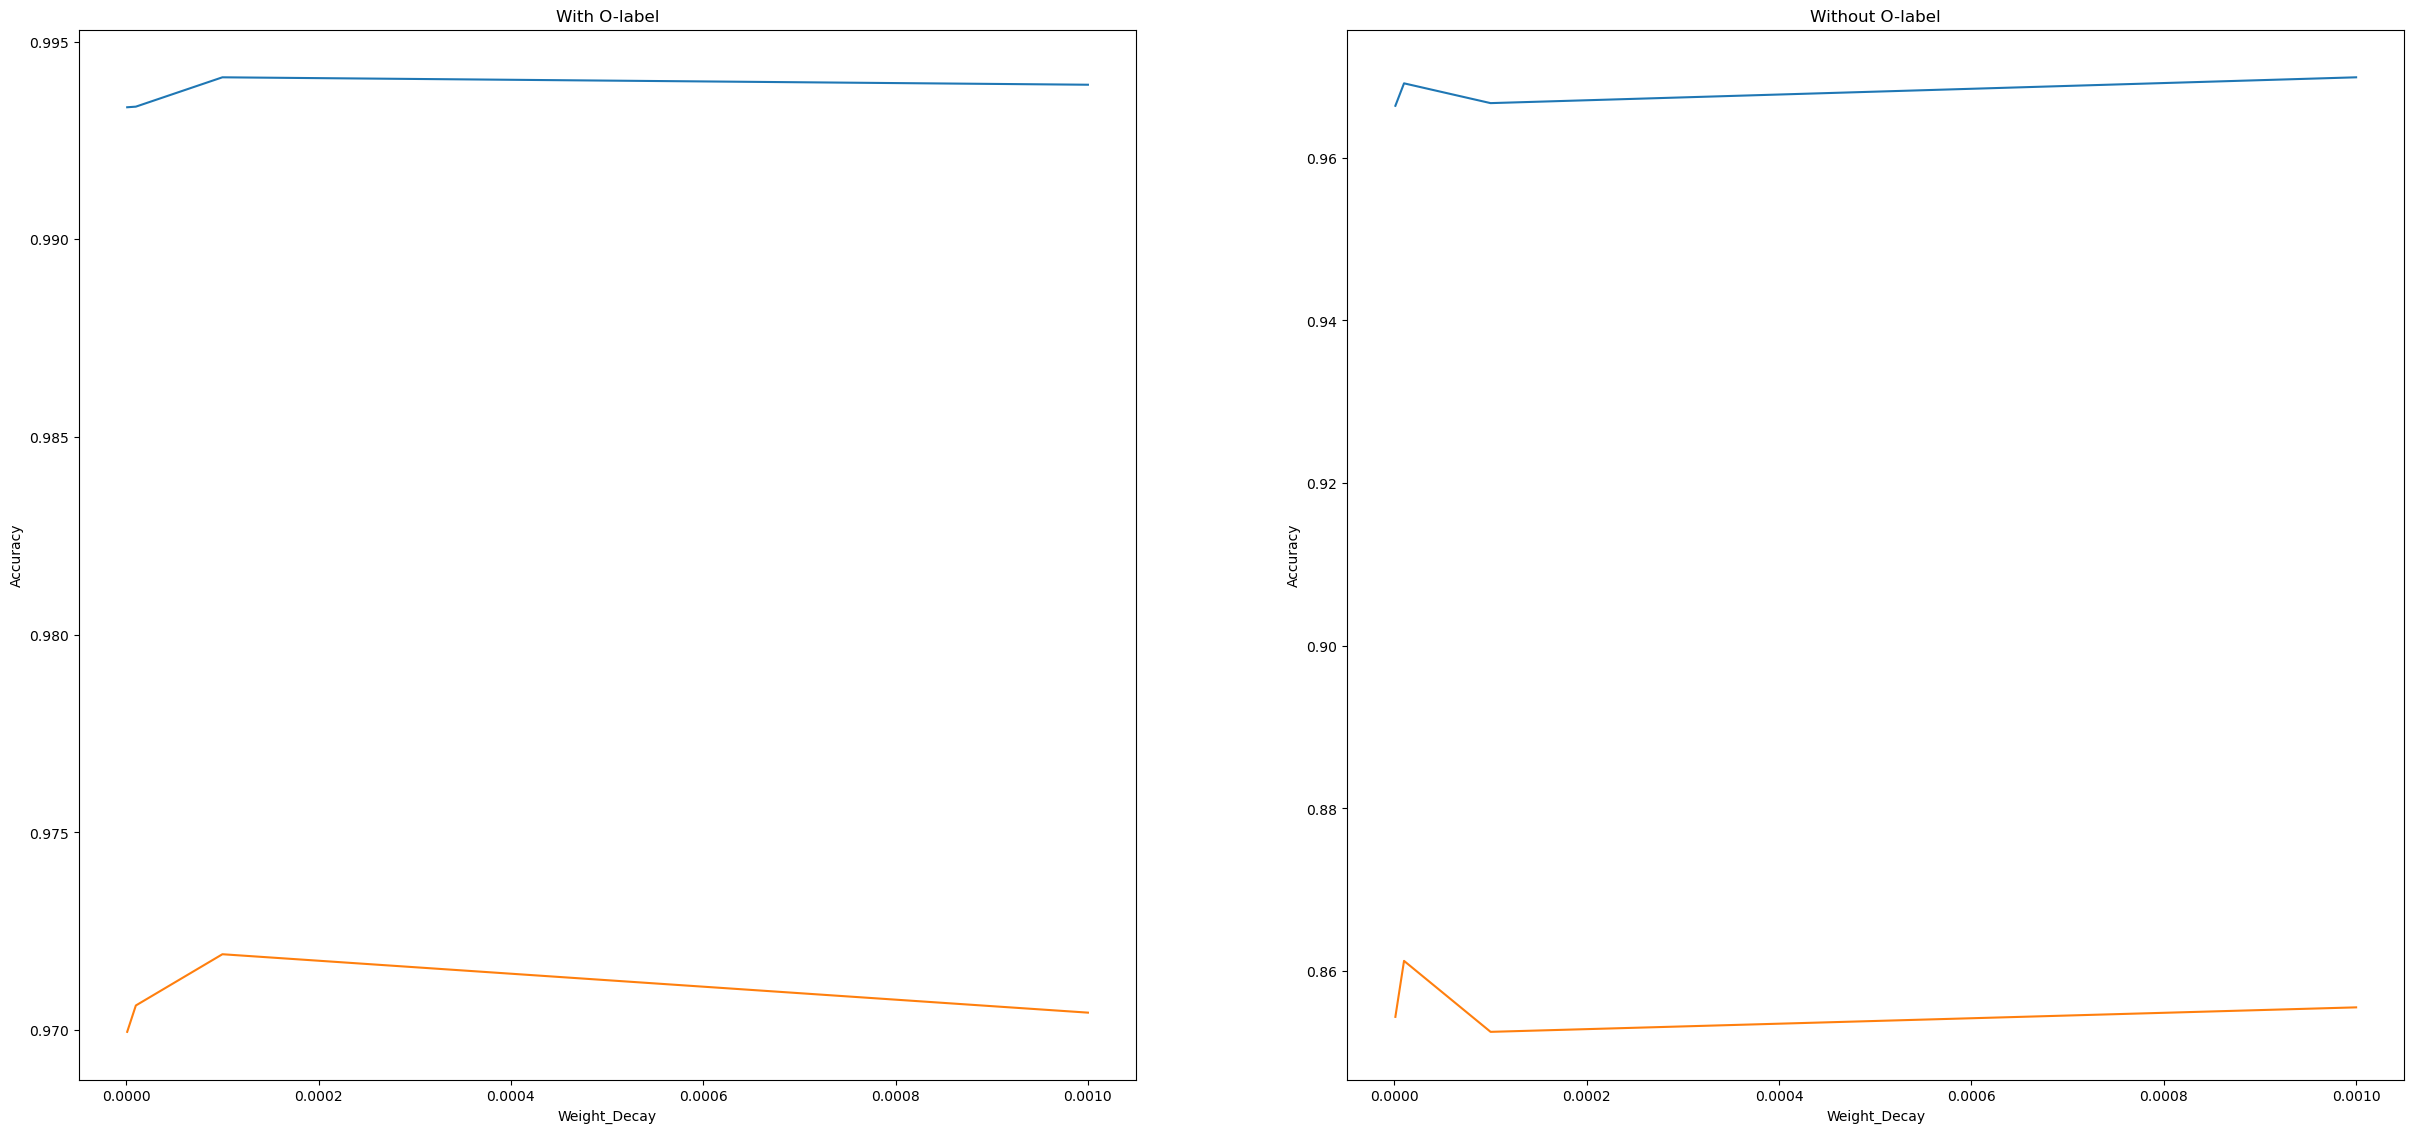

In [7]:
#weight_decay
wds = [1e-3,1e-4,1e-5,1e-6]
tas = []
ta_wos = []
vas = []
va_wos = []

for wd in wds:
    model = train(wd)
    a,ta,b,ta_wo,c,d = evaluate(model,train_dataloader,train_labels)
    h,va,g,va_wo,f,e = evaluate(model,val_dataloader,val_labels)
    tas.append(ta)
    vas.append(va)
    ta_wos.append(ta_wo)
    va_wos.append(va_wo)

fig1 = plt.figure(figsize = (30,30))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax1.plot(wds,tas)
ax1.plot(wds,vas)
# ax1.title("Without O-label")
ax1.set(xlabel='Weight_Decay', ylabel='Accuracy',title = "With O-label")
ax2.plot(wds,ta_wos)
ax2.plot(wds,va_wos)
ax2.set(xlabel='Weight_Decay', ylabel='Accuracy',title = "Without O-label")

plt.show()


A weight decay of 1e-5 is giving better results on the validation data

## Evaluation
For evaluating the performance of the model, you should make use of the `accuracy` metric. You should report the performance after removing the pads. Further, it would be better if you report the accuracy both with and without the "O" label.

In [7]:
model = train(1e-5)
train_f1,train_acc,train_f1_wO,train_acc_wO,t1,t11 = evaluate(model,train_dataloader,train_labels)
val_f1,val_acc,val_f1_wO,val_acc_wO,t2,t22         = evaluate(model,val_dataloader,val_labels)
test_f1,test_acc,test_f1_wO,test_acc_wO,t3,t33     = evaluate(model,test_dataloader,test_labels)

print("Training Results with O-label:")
print(f"Training weighted F1 Score: {train_f1}")
print(f"Training avg F1 Score: {t1}")
print(f"Training Accuracy: {train_acc*100} %")
print('\n')
print("Training Results without O-label:")
print(f"Training weighted F1 Score: {train_f1_wO}")
print(f"Training avg F1 Score: {t11}")
print(f"Training Accuracy: {train_acc_wO*100} %")
print('\n')
print("Validation Results with O-label:")
print(f"Validation weighted F1 Score: {val_f1}")
print(f"Validation avg F1 Score: {t2}")
print(f"Validation Accuracy: {val_acc*100} %")
print('\n')
print("Validation Results without O-label:")
print(f"Validation weighted F1 Score: {val_f1_wO}")
print(f"Valdiation avg F1 Score: {t22}")
print(f"Validation Accuracy: {val_acc_wO*100} %")
print('\n')
print("Testing Results with O-label:")
print(f"Testing weighted F1 Score: {test_f1}")
print(f"Testing avg F1 Score: {t3}")
print(f"Testing Accuracy: {test_acc*100} %")
print('\n')
print("Testing Results without O-label:")
print(f"Testing weighted F1 Score: {test_f1_wO}")
print(f"Testing avg F1 Score: {t33}")
print(f"Testing Accuracy: {test_acc_wO*100} %")
    

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epoch 1/20 - Batch 1199/1199 - Loss: 0.13859917223453522
Epoch 2/20 - Batch 1199/1199 - Loss: 0.069377750158309946
Epoch 3/20 - Batch 1199/1199 - Loss: 0.092299394309520724
Epoch 4/20 - Batch 1199/1199 - Loss: 0.076653353869915016
Epoch 5/20 - Batch 1199/1199 - Loss: 0.022658515721559525
Epoch 6/20 - Batch 1199/1199 - Loss: 0.0337128974497318344
Epoch 7/20 - Batch 1199/1199 - Loss: 0.018152339383959778
Epoch 8/20 - Batch 1199/1199 - Loss: 0.0222415924072265625
Epoch 9/20 - Batch 1199/1199 - Loss: 0.0096005965024232865
Epoch 10/20 - Batch 1199/1199 - Loss: 0.0047138095833361152
Epoch 11/20 - Batch 1199/1199 - Loss: 0.0082102790474891667
Epoch 12/20 - Batch 1199/1199 - Loss: 0.0060477922670543192
Epoch 13/20 - Batch 1199/1199 - Loss: 0.03400174528360367343
Epoch 14/20 - Batch 1199/1199 - Loss: 0.01468165032565593778
Epoch 15/20 - Batch 1199/1199 - Loss: 0.00125900853890925655
Epoch 16/20 - Batch 1199/1199 - Loss: 0.00038958722143433995
Epoch 17/20 - Batch 1199/1199 - Loss: 0.000489338010

Your final submission should include a report that describes your methodology, experimental results, analysis, and discussion, as well as the code used to train and test the model.

Good luck, and have fun exploring BERT!